In [1278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

df=pd.read_csv("ElecDeviceRatingPrediction.csv")
electro = df.copy()
electro.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Pentium Quad,Not Available,4 GB,LPDDR4X,0 GB,512 GB,64-bit Windows,0 GB,Casual,No warranty,No,No,45990,3 stars,0,0
1,ASUS,Intel,Core i5,10th,8 GB,LPDDR4,0 GB,512 GB,32-bit DOS,4 GB,Casual,No warranty,No,No,106167,4 stars,1881,241
2,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,64-bit Windows,0 GB,Casual,No warranty,No,No,22990,3 stars,0,0
3,Lenovo,Intel,Core i3,11th,4 GB,DDR4,256 GB,0 GB,64-bit Windows,0 GB,Casual,1 year,No,Yes,44990,4 stars,42,4
4,HP,AMD,Ryzen 7,Not Available,16 GB,DDR4,512 GB,0 GB,64-bit Windows,2 GB,Casual,1 year,No,Yes,79990,3 stars,23,6


In [1279]:
#check the datatypes
electro.dtypes

brand                object
processor_brand      object
processor_name       object
processor_gnrtn      object
ram_gb               object
ram_type             object
ssd                  object
hdd                  object
os                   object
graphic_card_gb      object
weight               object
warranty             object
Touchscreen          object
msoffice             object
Price                 int64
rating               object
Number of Ratings     int64
Number of Reviews     int64
dtype: object

In [1280]:
#convert to the correct datatype
electro['Touchscreen']=electro['Touchscreen'].astype('category')
electro['msoffice']=electro['msoffice'].astype('category')
electro['rating']=electro['rating'].str.strip('stars')
electro['rating']=electro['rating'].astype('category')
electro['ram_gb']=electro['ram_gb'].str.strip('GB')
electro['ram_gb']=electro['ram_gb'].astype('int')
electro['ssd']=electro['ssd'].str.strip('GB')
electro['ssd']=electro['ssd'].astype('int')
electro['hdd']=electro['hdd'].str.strip('GB')
electro['hdd']=electro['hdd'].astype('int')
electro['processor_brand']=electro['processor_brand'].astype('category')
electro['brand']=electro['brand'].astype('category')
electro['processor_name']=electro['processor_name'].astype('category')
electro['ram_type']=electro['ram_type'].astype('category')
electro['os']=electro['os'].astype('category')
electro['weight']=electro['weight'].astype('category')
electro['graphic_card_gb']=electro['graphic_card_gb'].str.strip('GB')
electro['graphic_card_gb']=electro['graphic_card_gb'].astype('int')
electro['warranty']=electro['warranty'].str.strip('year || years')
electro['warranty']=electro['warranty'].str.replace('No warranty','0')
electro['warranty']=electro['warranty'].astype('category')
electro['processor_gnrtn']=electro['processor_gnrtn'].str.strip('th')
electro['processor_gnrtn']=electro['processor_gnrtn'].str.replace('Not Available','0')


In [1281]:
electro.dtypes

brand                category
processor_brand      category
processor_name       category
processor_gnrtn        object
ram_gb                  int32
ram_type             category
ssd                     int32
hdd                     int32
os                   category
graphic_card_gb         int32
weight               category
warranty             category
Touchscreen          category
msoffice             category
Price                   int64
rating               category
Number of Ratings       int64
Number of Reviews       int64
dtype: object

In [1282]:
electro['processor_gnrtn'].unique()

array(['0', '10', '11', '8', '7', '12', '9', '4'], dtype=object)

In [1283]:
electro.loc[electro['processor_gnrtn'] == '0' , 'processor_gnrtn'] = electro['processor_gnrtn'].value_counts().idxmax()
electro['processor_gnrtn']=electro['processor_gnrtn'].astype('category')

In [1284]:
electro['processor_gnrtn'].unique()

['11', '10', '8', '7', '12', '9', '4']
Categories (7, object): ['10', '11', '12', '4', '7', '8', '9']

In [1285]:
electro['rating'].unique()

['3 ', '4 ', '5 ', '2 ', '1 ']
Categories (5, object): ['1 ', '2 ', '3 ', '4 ', '5 ']

In [1286]:
#check the ranges
electro.describe()

,ram_gb,ssd,hdd,graphic_card_gb,Price,Number of Ratings,Number of Reviews
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,8.724758,449.150761,232.984786,1.208852,77031.348548,301.217151,36.550484
std,4.439221,318.015040,416.286290,2.053125,45706.444883,970.519221,115.413126
min,4.000000,0.000000,0.000000,0.000000,16990.000000,0.000000,0.000000
25%,4.000000,256.000000,0.000000,0.000000,45960.000000,0.000000,0.000000
50%,8.000000,512.000000,0.000000,0.000000,64990.000000,17.000000,2.000000
75%,8.000000,512.000000,512.000000,2.000000,89846.000000,154.000000,19.500000
max,32.000000,3072.000000,2048.000000,8.000000,441990.000000,15279.000000,1947.000000


In [1287]:
#check for duplicates
duplicates = electro.duplicated(keep=False)
duplicates.sum()

30

In [1288]:
#drop the duplicates
electro.drop_duplicates(inplace=True)

In [1289]:
#check if they are deleted
duplicates = electro.duplicated(keep=False).sum()
duplicates

0

In [1290]:
#check if there is any device doesn't have any processor
electro[(electro['processor_gnrtn']=='0') & (electro['ssd']==0) & (electro['hdd']==0)]

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews


In [1291]:
#check missing data
electro.isna().sum()

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64

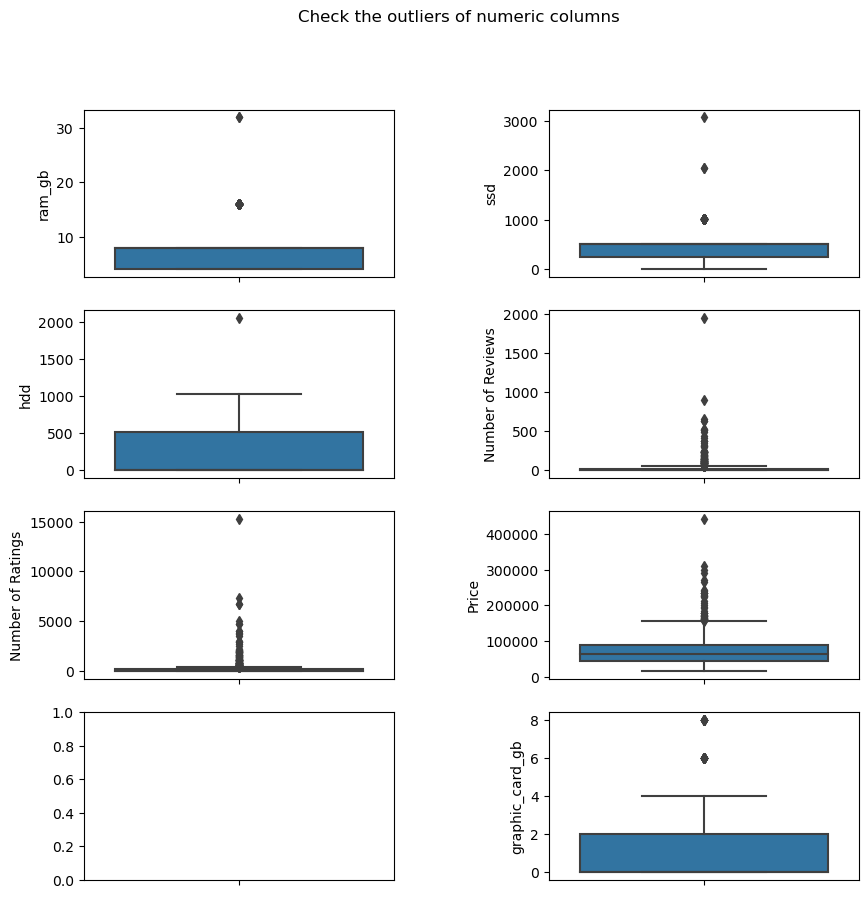

In [1292]:
#check the outliers
fig, axes = plt.subplots(4,2,sharex=True,figsize=(10, 10))
fig.suptitle('Check the outliers of numeric columns')
plt.subplots_adjust(wspace = 0.5)
sns.boxplot(data=electro, y='ram_gb', ax=axes[0,0])
sns.boxplot(data=electro, y='ssd', ax=axes[0,1])
sns.boxplot(data=electro, y='hdd', ax=axes[1,0])
sns.boxplot(data=electro, y='Number of Reviews', ax=axes[1,1])
sns.boxplot(data=electro, y='Number of Ratings', ax=axes[2,0])
sns.boxplot(data=electro, y='Price', ax=axes[2,1])
#sns.boxplot(data=electro, y='warranty', ax=axes[3,0])
sns.boxplot(data=electro, y='graphic_card_gb', ax=axes[3,1])
plt.show()

In [1293]:
#drop the outliers
for col in electro.columns:
        #print("capping the ",col)
        if (((electro[col].dtype)=='float') | ((electro[col].dtype)=='int32')|((electro[col].dtype)=='int64')):
            percentiles = electro[col].quantile([0.25,0.75]).values
            iqr= percentiles[1]-percentiles[0]
            electro[col][electro[col] <= percentiles[0]-1.5*iqr] = percentiles[0]
            electro[col][electro[col] >= percentiles[1]+1.5*iqr] = percentiles[1]
        else:
            electro[col]=electro[col]

C:\Users\DELL\AppData\Local\Temp\ipykernel_25928\1582183839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electro[col][electro[col] <= percentiles[0]-1.5*iqr] = percentiles[0]
C:\Users\DELL\AppData\Local\Temp\ipykernel_25928\1582183839.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electro[col][electro[col] >= percentiles[1]+1.5*iqr] = percentiles[1]
C:\Users\DELL\AppData\Local\Temp\ipykernel_25928\1582183839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

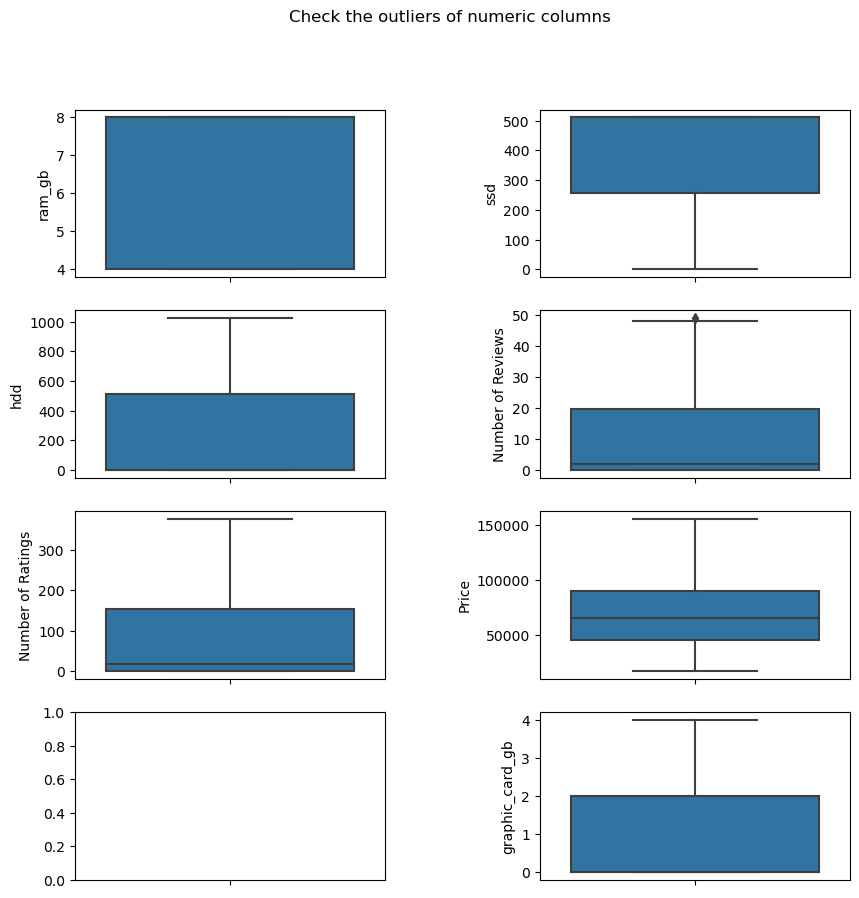

In [1294]:
#check the outliers
fig, axes = plt.subplots(4,2,sharex=True,figsize=(10, 10))
fig.suptitle('Check the outliers of numeric columns')
plt.subplots_adjust(wspace = 0.5)
sns.boxplot(data=electro, y='ram_gb', ax=axes[0,0])
sns.boxplot(data=electro, y='ssd', ax=axes[0,1])
sns.boxplot(data=electro, y='hdd', ax=axes[1,0])
sns.boxplot(data=electro, y='Number of Reviews', ax=axes[1,1])
sns.boxplot(data=electro, y='Number of Ratings', ax=axes[2,0])
sns.boxplot(data=electro, y='Price', ax=axes[2,1])
#sns.boxplot(data=electro, y='warranty', ax=axes[3,0])
sns.boxplot(data=electro, y='graphic_card_gb', ax=axes[3,1])
plt.show()

In [1295]:
electro

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Pentium Quad,11,4,LPDDR4X,0,512,64-bit Windows,0,Casual,No warrant,No,No,45990,3,0.0,0.00
1,ASUS,Intel,Core i5,10,8,LPDDR4,0,512,32-bit DOS,4,Casual,No warrant,No,No,106167,4,154.5,19.75
2,ASUS,Intel,Celeron Dual,11,4,DDR4,0,512,64-bit Windows,0,Casual,No warrant,No,No,22990,3,0.0,0.00
3,Lenovo,Intel,Core i3,11,4,DDR4,256,0,64-bit Windows,0,Casual,1,No,Yes,44990,4,42.0,4.00
4,HP,AMD,Ryzen 7,11,8,DDR4,512,0,64-bit Windows,2,Casual,1,No,Yes,79990,3,23.0,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,Lenovo,Intel,Core i3,11,4,DDR4,256,0,64-bit Windows,0,Casual,No warrant,No,No,39998,4,10.0,1.00
719,HP,Intel,Core i3,11,8,DDR4,512,0,64-bit Windows,0,ThinNlight,No warrant,No,No,44990,3,0.0,0.00
720,Lenovo,Intel,Core i5,11,8,DDR4,512,0,64-bit Windows,0,Casual,3,Yes,Yes,64990,4,48.0,12.00
721,MSI,Intel,Core i5,10,8,LPDDR4,0,512,32-bit DOS,2,Casual,No warrant,No,No,89918,4,24.0,5.00


In [1296]:
#label encoding for features with natural order 
label_encoder = LabelEncoder()  
electro['rating']= label_encoder.fit_transform(electro['rating'])
electro['weight']= label_encoder.fit_transform(electro['weight'])

In [1297]:
#one hot encoding for categories with no order
electro=pd.get_dummies(electro,columns=['brand','processor_brand','processor_name','processor_gnrtn','ram_type','os','Touchscreen','msoffice'],dtype=int)

In [1298]:
electro

,ram_gb,ssd,hdd,graphic_card_gb,weight,warranty,Price,rating,Number of Ratings,Number of Reviews,...,ram_type_LPDDR4X,os_32-bit DOS,os_32-bit Windows,os_64-bit DOS,os_64-bit Mac,os_64-bit Windows,Touchscreen_No,Touchscreen_Yes,msoffice_No,msoffice_Yes
0,4,0,512,0,0,No warrant,45990,2,0.0,0.00,...,1,0,0,0,0,1,1,0,1,0
1,8,0,512,4,0,No warrant,106167,3,154.5,19.75,...,0,1,0,0,0,0,1,0,1,0
2,4,0,512,0,0,No warrant,22990,2,0.0,0.00,...,0,0,0,0,0,1,1,0,1,0
3,4,256,0,0,0,1,44990,3,42.0,4.00,...,0,0,0,0,0,1,1,0,0,1
4,8,512,0,2,0,1,79990,2,23.0,6.00,...,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,4,256,0,0,0,No warrant,39998,3,10.0,1.00,...,0,0,0,0,0,1,1,0,1,0
719,8,512,0,0,2,No warrant,44990,2,0.0,0.00,...,0,0,0,0,0,1,1,0,1,0
720,8,512,0,0,0,3,64990,3,48.0,12.00,...,0,0,0,0,0,1,0,1,0,1
721,8,0,512,2,0,No warrant,89918,3,24.0,5.00,...,0,1,0,0,0,0,1,0,1,0


In [1299]:
#split to features and result
X = electro.drop(columns=['rating'])
Y = electro['rating']

C:\Users\DELL\AppData\Local\Temp\ipykernel_25928\3569436995.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = electro.corr()


<function matplotlib.pyplot.show(close=None, block=None)>

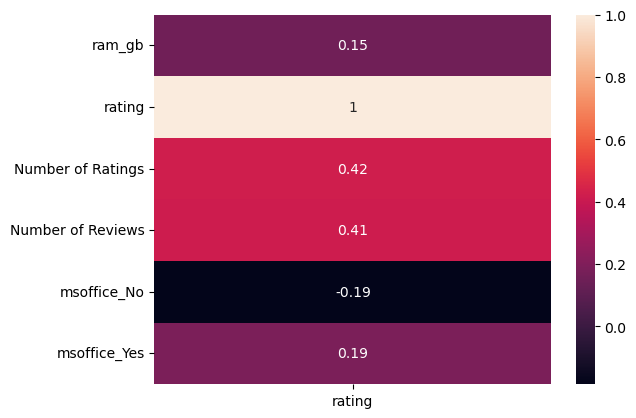

In [1300]:
#check the best features with Y
corr = electro.corr()
top_feature = corr.loc[abs(corr['rating'])>0.15,'rating']
top_feature=pd.DataFrame(top_feature)
sns.heatmap(top_feature,annot=True)
plt.show


In [1301]:
top_feature

,rating
ram_gb,0.153889
rating,1.000000
Number of Ratings,0.424428
Number of Reviews,0.413668
msoffice_No,-0.185313
msoffice_Yes,0.185313


In [1302]:
first_X= electro[top_feature.index]
Y=electro['rating']
first_X.pop('msoffice_No')
first_X

,ram_gb,rating,Number of Ratings,Number of Reviews,msoffice_Yes
0,4,2,0.0,0.00,0
1,8,3,154.5,19.75,0
2,4,2,0.0,0.00,0
3,4,3,42.0,4.00,1
4,8,2,23.0,6.00,1
...,...,...,...,...,...
718,4,3,10.0,1.00,0
719,8,2,0.0,0.00,0
720,8,3,48.0,12.00,1
721,8,3,24.0,5.00,0


In [1303]:
#normalize the data
scaler =  MinMaxScaler(feature_range=(0,1))
first_X= pd.DataFrame(scaler.fit_transform(first_X),index=first_X.index,columns=first_X.columns)


In [1304]:
first_X

,ram_gb,rating,Number of Ratings,Number of Reviews,msoffice_Yes
0,0.0,0.50,0.000000,0.000000,0.0
1,1.0,0.75,0.409814,0.403061,0.0
2,0.0,0.50,0.000000,0.000000,0.0
3,0.0,0.75,0.111406,0.081633,1.0
4,1.0,0.50,0.061008,0.122449,1.0
...,...,...,...,...,...
718,0.0,0.75,0.026525,0.020408,0.0
719,1.0,0.50,0.000000,0.000000,0.0
720,1.0,0.75,0.127321,0.244898,1.0
721,1.0,0.75,0.063660,0.102041,0.0


In [1305]:
#logistic regression model
X_train, X_test, y_train, y_test = train_test_split(first_X, Y, test_size=0.25, shuffle = True,random_state=104)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

logistic_model = LogisticRegression(max_iter = 300)
scores = cross_val_score(logistic_model, X_train, y_train, 
                         cv=cv)

print("Accuracy : " ,scores.mean())


Accuracy :  0.958454281567489


In [1306]:
# Plot the data points
#plt.scatter(X_train['Number of Ratings'], y_train,cmap='viridis', marker='o', label='Data')
#print(X_train.size, y_train.size)
# Plot the logistic regression curve
#logistic_model.fit(X_train, y_train)
#X_test_log = np.linspace(np.min(X_train), np.max(X_train), 300)
#y_prob = logistic_model.predict_proba(X_test_log)
#plt.plot(X_test_log, y_prob, color='red', label='Logistic Regression Curve')

#plt.xlabel('Number of Ratings')
#plt.ylabel('Rating')
#plt.title('Logistic Regression Curve')
#plt.legend()
#plt.show()
#sns.regplot(x = X_train['Number of Reviews'], y = y_train, data = X_train, logistic=True, ci = None, scatter_kws={'color': 'black'}, line_kws={'color': 'red'})
#sns.regplot(x = X_train['Number of Ratings'], y = y_train, data = X_train, logistic=True, ci = None, scatter_kws={'color': 'black'}, line_kws={'color': 'red'})
#sns.regplot(x = X_train['ram_gb'], y = y_train, data = X_train, logistic=True, ci = None, scatter_kws={'color': 'black'}, line_kws={'color': 'red'})
#sns.regplot(x = X_train['msoffice_Yes'], y = y_train, data = X_train, logistic=True, ci = None, scatter_kws={'color': 'black'}, line_kws={'color': 'red'})

In [1307]:
#linear regression model
Y = electro[['rating']]
Y=pd.DataFrame(scaler.fit_transform(Y),index=Y.index,columns=Y.columns)
X_train, X_test, y_train, y_test = train_test_split(first_X,Y , 
                                   random_state=104,  
                                   test_size=0.25,  
                                   shuffle=True)
model = LinearRegression()
cv = KFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(model, X_train, y_train, 
                         cv=cv)

print("Accuracy : " ,scores.mean())

Accuracy :  1.0


In [1308]:
#lasso regression model
Y = electro[['rating']]
Y=pd.DataFrame(scaler.fit_transform(Y),index=Y.index,columns=Y.columns)
X_train, X_test, y_train, y_test = train_test_split(first_X,Y , 
                                   random_state=104,  
                                   test_size=0.25,  
                                   shuffle=True)
model = Lasso(alpha = 0.0062)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(model, X_train, y_train, 
                         cv=cv)

print("Accuracy : " ,scores.mean())

Accuracy :  0.9032022149310268


In [1309]:
#ridge regression model
model = Ridge(alpha=4)
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(model, X_train, y_train, 
                         cv=cv)

print("Accuracy : " ,scores.mean())

Accuracy :  0.9033998913442144


In [1310]:
#polynomial regression model
polyFeatures = PolynomialFeatures(degree=2, include_bias=False)
model = make_pipeline(polyFeatures, LinearRegression())
scores = cross_val_score(model, X_train, y_train, 
                         cv=cv)

print("Accuracy : " ,scores.mean())

Accuracy :  1.0
